In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
from math import floor, ceil

# Reading Data from Files

In [13]:
fileprefix = "final" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [222]:
part_stats_dicts = []
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    avgClickLevel = []
    rewardsWithheld = []
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
#         if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
#             print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    mEnv.step(int(click))
                
                
                # Saving the number of clicks and the average distance of all clicks
                numClicks.append(len(clicks))
                clicksL1 = len([c for c in clicks if int(c) in [1,5,9]])
                clicksL2 = len([c for c in clicks if int(c) in [2,6,10]])
                clicksL3 = len([c for c in clicks if int(c) in [3,4,7,8,11,12]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3)/len(clicks)
                except:
                    avgLevel = 0
                    
                avgClickLevel.append(avgLevel)
                expectedScores.append(mEnv._term_reward()) #+ trial['trialdata']['costs'])
                
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                demographicsAvailable = True
                
        if trial_id.startswith("finish_fail"):
            demographicsAvailable = True
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
            
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "demographicsAvailable": demographicsAvailable
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

60fd5adad03767cff6dddda8
631a24dfca851aac1863e4a4
601903cdcd7cd6213bf60d64
5c629b836e03a00001d47bdd
615f4115250650ede6f83270
608c0288bce208aa19b5e302
60e43d16eb3536f1618652fb
6165d04961f94aba783d4529
611cccc7df12bfa05e6135e0
615aff05691d41b8ce734ca0
6115fcb4fcbab96f3ceb1734
5d7d00bb64f400001bd72301
60143a1a222eb43daf203877
5dafea4de40355001651fa2f
5ae7cdd9a0e4390001f08f12
5d21e78e5a2cea0016a843c4
6081e753b16df5194cf90f49
5e5012ec47808406305d6a0d
6155d029515651d612ad2141
5e89d0a17ec160000888ee98
5ebdb1414b3e5d0e1e46e76d
604b169fe4b7991ec08da3a6
60217ceca41dfb1639d152a7
5efd2964d36f63162f263795
5f16ccc87d339d0008e08016
60fe8586944a3f20fd5e8db2
5ec51242bc5aac433c0450ec
60a2d0f8a996c447692d4b73
5ec79cbd44972a1fceed2719
5f388a9c9604723a294bc377
5f69e356d68b93020e622bf2
60f88d7fef1959734061e5a7
5974ce5364b35a00019dd811
6088a7e22d5b98ef3f813a22
610ce0a48fc7e68abc4070c1
5aa54dca873cda00012cfaf8
No data
5f2664edcb7a443902254785
5eb2e299831ce0092dd2b965
6163d356472f53c054893857
5f4f9d1609e969066

In [223]:
# Compiling all data into trial data

all_trial_data = {
    "trialScores": [],
    "expectedScores": [],
    "numClicks" : [],
    "avgClickLevel" : [],
    "trialNumbers": [],
    "scarce": [],
    "numRewardedTrials": [],
    "numUnrewardedTrials": [],
    "workerId": [],
    "rewardsWithheld" : [],
}

count = 0;

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30, 120]:
        print(part['condition'], part['workerId'], "MDP Data Incomplete")
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    count += 1
    all_trial_data['trialScores'] += part['trialScores']
    all_trial_data['rewardsWithheld'] += part['rewardsWithheld']
    all_trial_data['workerId'] += [part['workerId']] * len(part['trialScores'])
    all_trial_data['expectedScores'] += part['expectedScores']
    all_trial_data['numClicks'] += part['numClicks']
    all_trial_data['avgClickLevel'] += part['avgClickLevel']
    all_trial_data['trialNumbers'] += list(range(1,len(part['trialScores'])+1))
    all_trial_data['scarce'] += [int(len(part['trialScores']) == 120)] * len(part['trialScores'])
    all_trial_data['numRewardedTrials'] += [i - sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]
    all_trial_data['numUnrewardedTrials'] += [sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]

all_trials_df = pd.DataFrame(all_trial_data)


1 601903cdcd7cd6213bf60d64 MDP Data Incomplete
0 5f16ccc87d339d0008e08016 MDP Data Incomplete
0 60a2d0f8a996c447692d4b73 Demographics missing
0 5974ce5364b35a00019dd811 MDP Data Incomplete
0 610ce0a48fc7e68abc4070c1 MDP Data Incomplete
1 6131460946d0022f68082db6 MDP Data Incomplete
0 5d8aa1e3eab19600163d9ab7 Demographics missing
0 5db9e0044a8eb40431d5e782 Demographics missing
0 60ceaf82080f57fb967341d2 MDP Data Incomplete
0 6103872a37b1dd5b8f350237 MDP Data Incomplete
0 6155a6764b2556042551a827 MDP Data Incomplete
0 5f2dc74f1f22490fbef32149 MDP Data Incomplete
0 60e122a66ca94d24c01664fa MDP Data Incomplete
1 614c58edcb19b4cb3a486666 MDP Data Incomplete
0 5df97fcd11d8796fd29e85e3 MDP Data Incomplete
1 6064b073d8b83b30f7975c8d MDP Data Incomplete
0 5b9207898a79b000013f9efe Demographics missing
1 60df3a39f23b7c55e0669e7b MDP Data Incomplete
0 60fef59b4d85390bc0357a7d MDP Data Incomplete
0 5f3a76043bb11c6786e731bf MDP Data Incomplete
1 60e5d224c2070a7adc97befe MDP Data Incomplete
1 6148c15

In [224]:
all_trials_df

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,23.0,28.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False
1,39.0,44.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False
2,-30.0,4.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False
3,24.0,22.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False
4,52.0,50.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False
...,...,...,...,...,...,...,...,...,...,...
15685,51.0,48.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False
15686,42.0,48.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False
15687,60.0,48.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False
15688,43.0,48.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False


## Removing Outliers

In [225]:
# Group statistics by participant
all_part_groups = all_trials_df.groupby('workerId')
control_part_groups = all_trials_df.loc[all_trials_df.scarce==0].groupby("workerId")
scarce_part_groups = all_trials_df.loc[all_trials_df.scarce==1].groupby("workerId")

# Get the averages of each statistic by participant
control_part_averages = control_part_groups.mean()
scarce_part_averages = scarce_part_groups.mean()
all_part_averages = all_part_groups.mean()

# Compute the proportion of trials with no clicks
all_part_averages['pctgSomeClick'] = (all_part_groups.apply(lambda x: x[x > 0].count()) / all_part_groups.count())['numClicks']
scarce_part_averages['pctgSomeClick'] = (scarce_part_groups.apply(lambda x: x[x > 0].count()) / scarce_part_groups.count())['numClicks']
control_part_averages['pctgSomeClick'] = (control_part_groups.apply(lambda x: x[x > 0].count()) / control_part_groups.count())['numClicks']

### Visualization of Distributions of Exclusion Criteria Statistics

In [226]:
all_part_averages.corr()

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,rewardsWithheld,pctgSomeClick
trialScores,1.000000,0.967723,0.691152,0.861070,0.216591,0.216591,0.195276,0.216492,0.216591,0.811888
expectedScores,0.967723,1.000000,0.760319,0.866466,0.123006,0.123006,0.111242,0.122942,0.123006,0.829417
numClicks,0.691152,0.760319,1.000000,0.467142,0.077138,0.077138,0.066238,0.077181,0.077138,0.603476
avgClickLevel,0.861070,0.866466,0.467142,1.000000,0.092145,0.092145,0.086374,0.092024,0.092145,0.903646
trialNumbers,0.216591,0.123006,0.077138,0.092145,1.000000,1.000000,0.884972,0.999939,1.000000,0.027856
scarce,0.216591,0.123006,0.077138,0.092145,1.000000,1.000000,0.884972,0.999939,1.000000,0.027856
numRewardedTrials,0.195276,0.111242,0.066238,0.086374,0.884972,0.884972,1.000000,0.879755,0.884972,0.038615
numUnrewardedTrials,0.216492,0.122942,0.077181,0.092024,0.999939,0.999939,0.879755,1.000000,0.999939,0.027522
rewardsWithheld,0.216591,0.123006,0.077138,0.092145,1.000000,1.000000,0.884972,0.999939,1.000000,0.027856
pctgSomeClick,0.811888,0.829417,0.603476,0.903646,0.027856,0.027856,0.038615,0.027522,0.027856,1.000000


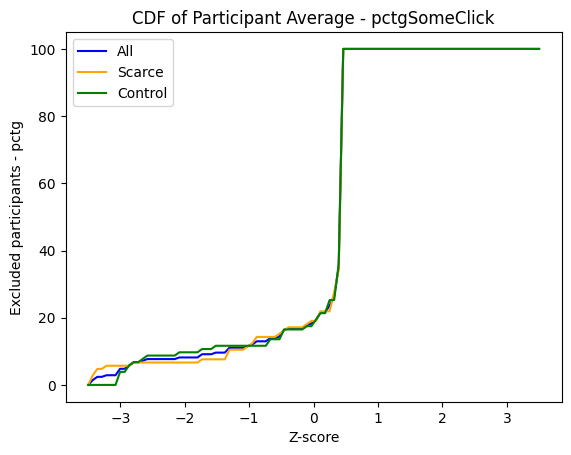

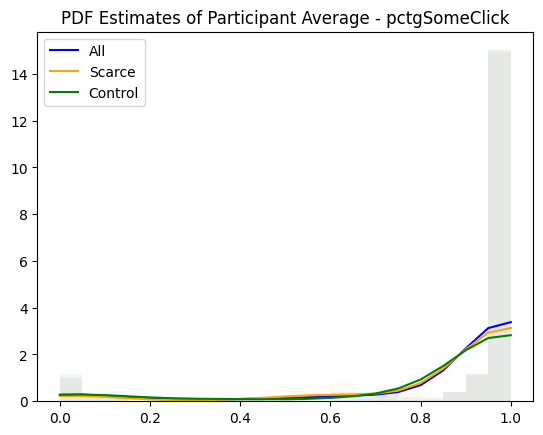

In [227]:
# Sensitivity analysis of zscore threshold for exclusion


exclusion_criteria = "pctgSomeClick" # column of all_part_averages
z_threshs = np.linspace(-3.5, 3.5, 100);

excluded = {
    "scarce": {
        "abs": [],
        "pctg": []
    },
    "control": {
        "abs": [],
        "pctg": []
    },
    "all": {
        "abs": [],
        "pctg": []
    }
    
}
for thresh in z_threshs:
    excluded_parts_control = control_part_averages[scipy.stats.zscore(control_part_averages[exclusion_criteria]) < thresh]
    included_parts_control = control_part_averages[scipy.stats.zscore(control_part_averages[exclusion_criteria]) >= thresh]

    excluded_parts_scarce = scarce_part_averages[scipy.stats.zscore(scarce_part_averages[exclusion_criteria]) < thresh]
    included_parts_scarce = scarce_part_averages[scipy.stats.zscore(scarce_part_averages[exclusion_criteria]) >= thresh]

    num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

    excluded["all"]["abs"].append(num_excluded_parts)
    excluded["all"]["pctg"].append(100 * num_excluded_parts / len(all_trials_df.groupby("workerId")))
    
    excluded["control"]["abs"].append(len(excluded_parts_control))
    excluded["control"]["pctg"].append(100 * len(excluded_parts_control) / len(control_part_averages))
                                     
    excluded["scarce"]["abs"].append(len(excluded_parts_scarce))
    excluded["scarce"]["pctg"].append(100 * len(excluded_parts_scarce) / len(scarce_part_averages))

which_plot = "pctg" #abs, pctg
plt.title("CDF of Participant Average - {}".format(exclusion_criteria))
plt.plot(z_threshs, excluded["all"][which_plot], label = "All",color='b')
plt.plot(z_threshs, excluded["scarce"][which_plot], label = "Scarce", color='orange')
plt.plot(z_threshs, excluded["control"][which_plot], label = "Control", color='g')
plt.xlabel("Z-score")
plt.ylabel("Excluded participants - {}".format(which_plot))
plt.legend()

plt.figure()
binwidth = 0.05
data = all_part_averages[exclusion_criteria]
plt.title("PDF Estimates of Participant Average - {}".format(exclusion_criteria))
density_all = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='b', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_all(x), label="All", color='b')

data = scarce_part_averages[exclusion_criteria]                   
density_s = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='orange', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_s(x), label="Scarce", color='orange')

data = control_part_averages[exclusion_criteria]      
density_c = scipy.stats.gaussian_kde(data)
n, x, _ = plt.hist(data, density=True, color='g', alpha=0.05, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(x, density_c(x), label="Control", color='g')

plt.legend()
                                                                       
plt.show()

In [228]:
# Select the exclusion criteria

selected_exclusion_col = "pctgSomeClick"

In [229]:
az_pclicks = all_part_averages.copy()
az_pclicks['z_pclicks'] = scipy.stats.zscore(az_pclicks['pctgSomeClick'])

az_pclicks.min()

trialScores            -5.733333
expectedScores          0.000000
numClicks               0.000000
avgClickLevel           0.000000
trialNumbers           15.500000
scarce                  0.000000
numRewardedTrials      14.500000
numUnrewardedTrials     0.000000
rewardsWithheld         0.000000
pctgSomeClick           0.000000
z_pclicks              -3.229073
dtype: float64

### Removing Based on Selected Criteria

In [230]:
len(scarce_part_averages[scarce_part_averages['pctgSomeClick'] <= 0.2])

7

In [231]:
# Removing outliers 

# Excluding participants who have exclusion criteria further than X deviations from mean

# Excluding those that have 100% of their trials with no clicks

#zscore_threshold = 0

zscore_threshold = (0.0 - all_part_averages[selected_exclusion_col].mean()) / all_part_averages[selected_exclusion_col].std()
print(zscore_threshold)
excluded_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] == 0]
included_parts_control = control_part_averages[control_part_averages[selected_exclusion_col] > 0]

zscore_threshold = (0.0 - scarce_part_averages[selected_exclusion_col].mean()) / scarce_part_averages[selected_exclusion_col].std()
#print(zscore_threshold)
excluded_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] == 0]
included_parts_scarce = scarce_part_averages[scarce_part_averages[selected_exclusion_col] > 0]

num_excluded_parts = len(excluded_parts_scarce) + len(excluded_parts_control)

print("Number of participants excluded: {0} ({1:0.2f}%)".format(
    num_excluded_parts,
    100 * num_excluded_parts /len(all_trials_df.groupby("workerId"))
))
print("\tControl: {0} ({1:0.2f}%)".format(
    len(excluded_parts_control),
    100 * len(excluded_parts_control) / len(control_part_averages)
))
print("\tScarce: {0} ({1:0.2f}%)".format(
    len(excluded_parts_scarce),
    100 * len(excluded_parts_scarce) / len(scarce_part_averages)
))
included_part_IDs = list(included_parts_scarce.index) + list(included_parts_control.index)
outliers_excluded_part = all_trials_df.loc[all_trials_df.workerId.isin(included_part_IDs)].reset_index(drop=True)
outliers_excluded_part['trialNumbers'] = outliers_excluded_part['trialNumbers'].astype('int64')
outliers_excluded_part['scarce'] = outliers_excluded_part['scarce'].astype('int64')
outliers_excluded_part['numRewardedTrials'] = outliers_excluded_part['numRewardedTrials'].astype('int64')
outliers_excluded_part['numUnrewardedTrials'] = outliers_excluded_part['numUnrewardedTrials'].astype('int64')


print("Number of total trials excluded: {0} ({1:0.2f}%)".format(len(all_trials_df)-len(outliers_excluded_part), 100-100*len(outliers_excluded_part)/(len(all_trials_df))))


-3.2213015652632673
Number of participants excluded: 7 (3.37%)
	Control: 4 (3.88%)
	Scarce: 3 (2.86%)
Number of total trials excluded: 480 (3.06%)


In [232]:
# Data to use for the remainder of the analysis

filtered_data = outliers_excluded_part

In [233]:
filtered_data

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld
0,23.0,28.0,6,2.000000,1,0,0,0,60fd5adad03767cff6dddda8,False
1,39.0,44.0,6,2.000000,2,0,1,0,60fd5adad03767cff6dddda8,False
2,-30.0,4.0,7,2.142857,3,0,2,0,60fd5adad03767cff6dddda8,False
3,24.0,22.0,7,2.142857,4,0,3,0,60fd5adad03767cff6dddda8,False
4,52.0,50.0,7,2.142857,5,0,4,0,60fd5adad03767cff6dddda8,False
...,...,...,...,...,...,...,...,...,...,...
15205,51.0,48.0,2,3.000000,26,0,25,0,601912cd193759016f9ba75b,False
15206,42.0,48.0,5,3.000000,27,0,26,0,601912cd193759016f9ba75b,False
15207,60.0,48.0,1,3.000000,28,0,27,0,601912cd193759016f9ba75b,False
15208,43.0,48.0,4,3.000000,29,0,28,0,601912cd193759016f9ba75b,False


# Visualizing Data

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_6160/3024295423.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))


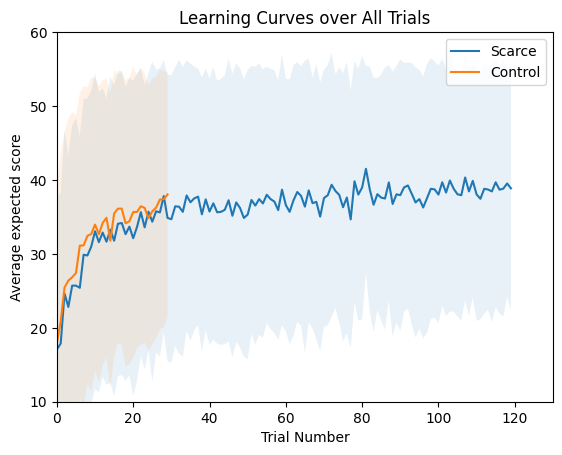

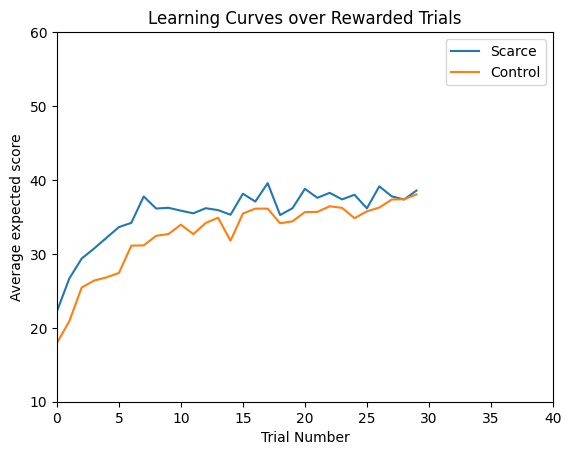

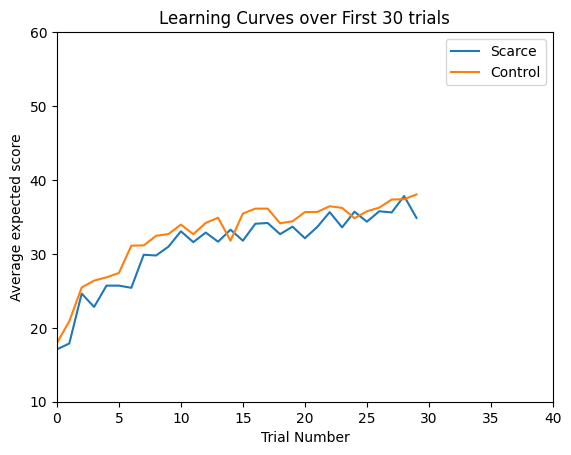

In [234]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_data_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["expectedScores"])
scarce_data_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["expectedScores"])
control_data = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["expectedScores"])
control_data_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["expectedScores"])
scarce_data_first_30 = scarce_data_all[0:30]
scarce_data_first_30_sd = scarce_data_all_sd[0:30]

# Taking only the rewarded trials in the scarce condition
rewarded_trials_df = pd.DataFrame(columns=data_to_copy.columns)
for worker in np.unique(data_to_copy.workerId):
    workerRows = data_to_copy.loc[(data_to_copy.scarce == 1) & (data_to_copy.workerId == worker)].reset_index(drop=True)
    rewarded = workerRows.loc[workerRows.rewardsWithheld == False]
    rewarded['trialNumbers'] = list(range(1,len(rewarded)+1))
    rewarded_trials_df = pd.concat([rewarded_trials_df,rewarded], ignore_index=True)

rewarded_trials_df['trialNumbers'] = rewarded_trials_df['trialNumbers'].astype("int64")
rewarded_trials_df['scarce'] = rewarded_trials_df['scarce'].astype("int64")
rewarded_trials_df['numRewardedTrials'] = rewarded_trials_df['numRewardedTrials'].astype("int64")
rewarded_trials_df['numUnrewardedTrials'] = rewarded_trials_df['numUnrewardedTrials'].astype("int64")
rewarded_trials_df['rewardsWithheld'] = rewarded_trials_df['rewardsWithheld'].astype("boolean")
scarce_data_rewarded = np.array(rewarded_trials_df.groupby('trialNumbers').mean()["expectedScores"])
scarce_data_rewarded_sd = np.array(rewarded_trials_df.groupby('trialNumbers').std()["expectedScores"])

plt.figure()
plt.title("Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over Rewarded Trials")
plt.plot(list(range(len(scarce_data_rewarded))), scarce_data_rewarded, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()

plt.figure()
plt.title("Learning Curves over First 30 trials")
plt.plot(list(range(len(scarce_data_first_30))), scarce_data_first_30, label="Scarce")
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 40])
plt.xlabel("Trial Number")
plt.ylabel("Average expected score")
plt.show()



## Visualizing Clicks

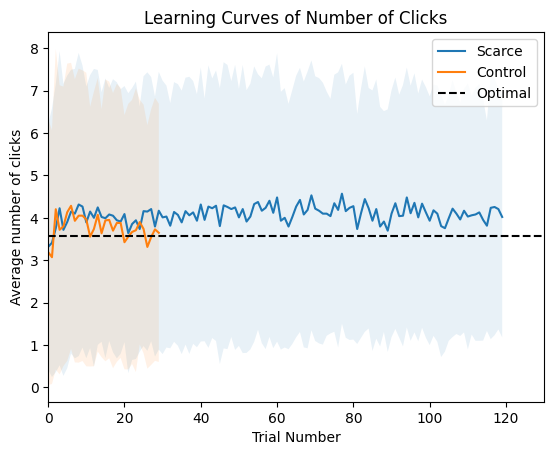

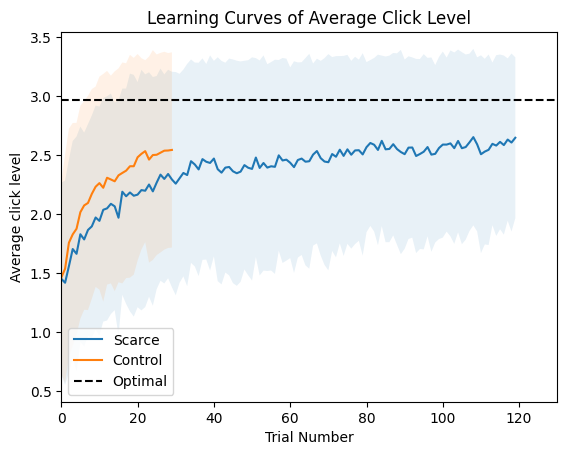

In [28]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# Taking the mean expected score over all trials 
scarce_level_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["avgClickLevel"])
scarce_level_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["avgClickLevel"])
control_level_all = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["avgClickLevel"])
control_level_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["avgClickLevel"])

# Taking the mean expected score over all trials 
scarce_num_all = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').mean()["numClicks"])
scarce_num_all_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 1].groupby('trialNumbers').std()["numClicks"])
control_num_all = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').mean()["numClicks"])
control_num_sd = np.array(data_to_copy.loc[data_to_copy.scarce == 0].groupby('trialNumbers').std()["numClicks"])

plt.figure()
plt.title("Learning Curves of Number of Clicks")
plt.plot(list(range(len(scarce_num_all))), scarce_num_all, label="Scarce")
plt.fill_between(list(range(len(scarce_num_all))), scarce_num_all + scarce_num_all_sd, scarce_num_all - scarce_num_all_sd, alpha=0.1)
plt.plot(list(range(len(control_num_all))), control_num_all, label="Control")
plt.fill_between(list(range(len(control_num_all))), control_num_all + control_num_sd, control_num_all - control_num_sd, alpha=0.1)
plt.axhline(3.56, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average number of clicks")
plt.show()

plt.figure()
plt.title("Learning Curves of Average Click Level")
plt.plot(list(range(len(scarce_level_all))), scarce_level_all, label="Scarce")
plt.fill_between(list(range(len(scarce_level_all))), scarce_level_all + scarce_level_all_sd, scarce_level_all - scarce_level_all_sd, alpha=0.1)
plt.plot(list(range(len(control_level_all))), control_level_all, label="Control")
plt.fill_between(list(range(len(control_level_all))), control_level_all + control_level_sd, control_level_all - control_level_sd, alpha=0.1)
plt.axhline(2.968, color='k', label='Optimal', linestyle="--")
plt.legend()
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average click level")
plt.show()




# 0.1 - Transforming Response Data

In [29]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

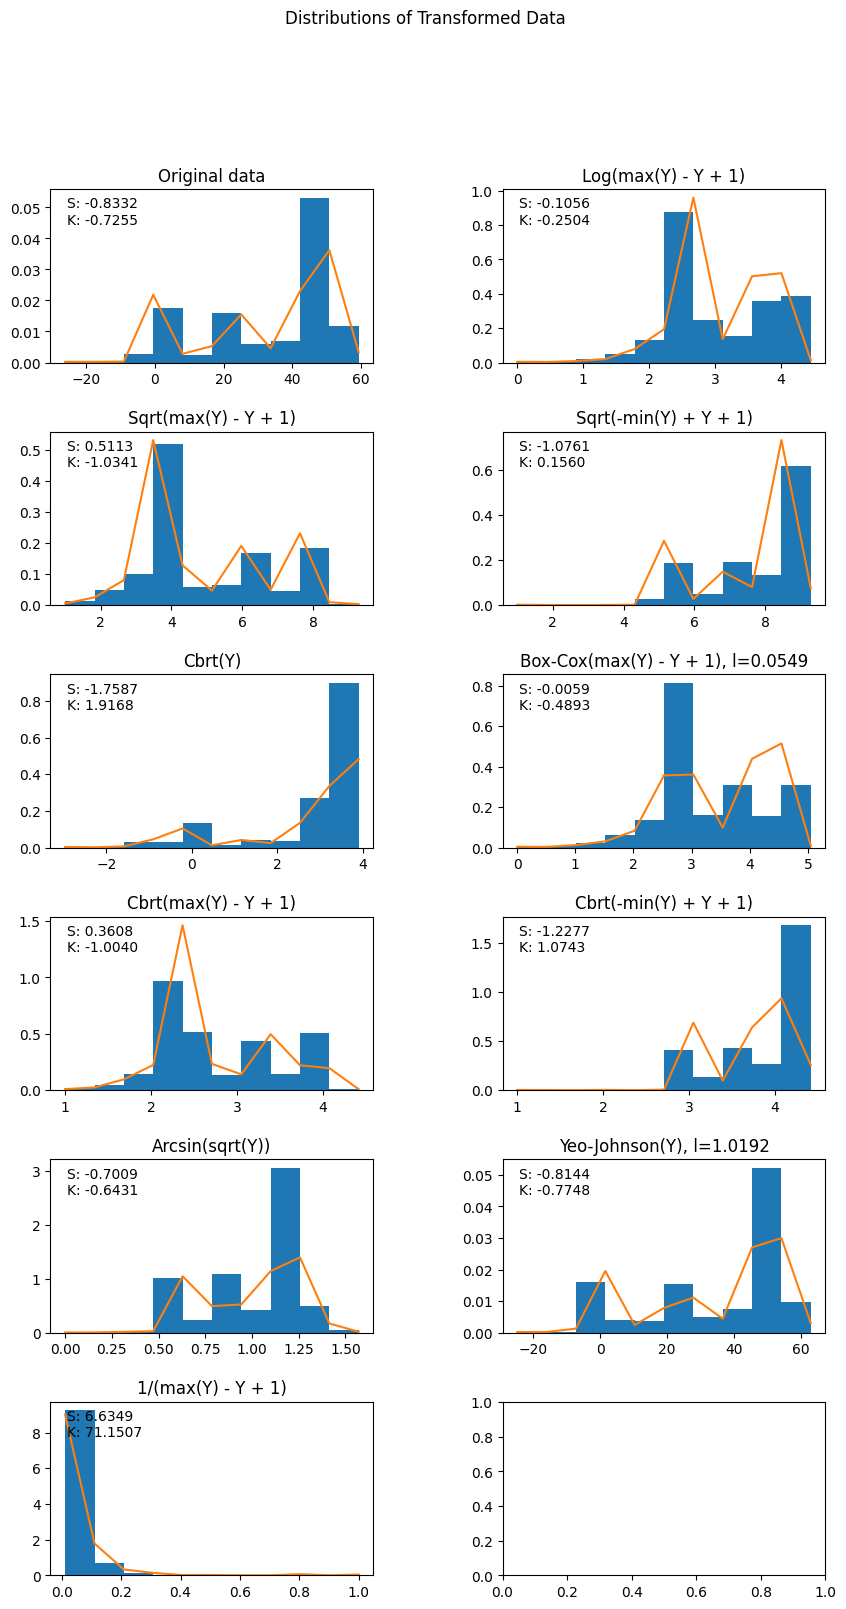

In [194]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded

transformed_trials_df = data_to_copy.copy()
log_transformed_trials_df = data_to_copy.copy()
sq_transformed_trials_df = data_to_copy.copy()
sq2_transformed_trials_df = data_to_copy.copy()
cb_transformed_trials_df = data_to_copy.copy()
cb2_transformed_trials_df = data_to_copy.copy()
cb3_transformed_trials_df = data_to_copy.copy()
arcsin_transformed_trials_df = data_to_copy.copy()
bc_transformed_trials_df = data_to_copy.copy()
yj_transformed_trials_df = data_to_copy.copy()
inverse_transformed_trials_df = data_to_copy.copy()


log_transformed_trials_df['expectedScores'] = np.log(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
sq_transformed_trials_df['expectedScores'] = np.sqrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
sq2_transformed_trials_df['expectedScores'] = np.sqrt(-transformed_trials_df['expectedScores'].min() + 1 + transformed_trials_df['expectedScores'])
cb_transformed_trials_df['expectedScores'] = np.cbrt(transformed_trials_df['expectedScores'])
cb2_transformed_trials_df['expectedScores'] = np.cbrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
cb3_transformed_trials_df['expectedScores'] = np.cbrt(-transformed_trials_df['expectedScores'].min() + 1 + transformed_trials_df['expectedScores'])
arcsin_transformed_trials_df['expectedScores'] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df['expectedScores'], 0, 1)))
bc_transformed_trials_df['expectedScores'],lam = scipy.stats.boxcox(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
#logit_transformed_trials_df['expectedScores'] = scipy.special.logit(scale_to_range(transformed_trials_df['expectedScores'], 0, 1))
yj_transformed_trials_df['expectedScores'],lam_y = scipy.stats.yeojohnson(transformed_trials_df['expectedScores'])
inverse_transformed_trials_df['expectedScores'] = 1/(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])

trans_list = [
    (transformed_trials_df, "Original data"),
    (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
    (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
    (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
    (cb_transformed_trials_df, "Cbrt(Y)"),
    (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
    (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
    (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
    (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
    (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
    (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
]

fig, ax = plt.subplots(nrows=math.ceil(len(trans_list)/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list)/2)),squeeze=False)
plt.suptitle("Distributions of Transformed Data")
ax = ax.flatten()

for idx, trans in enumerate(trans_list):
    data = trans[0]['expectedScores']
    label = trans[1]
    skew = scipy.stats.skew(data)
    density = scipy.stats.gaussian_kde(data)
    kurtosis = scipy.stats.kurtosis(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

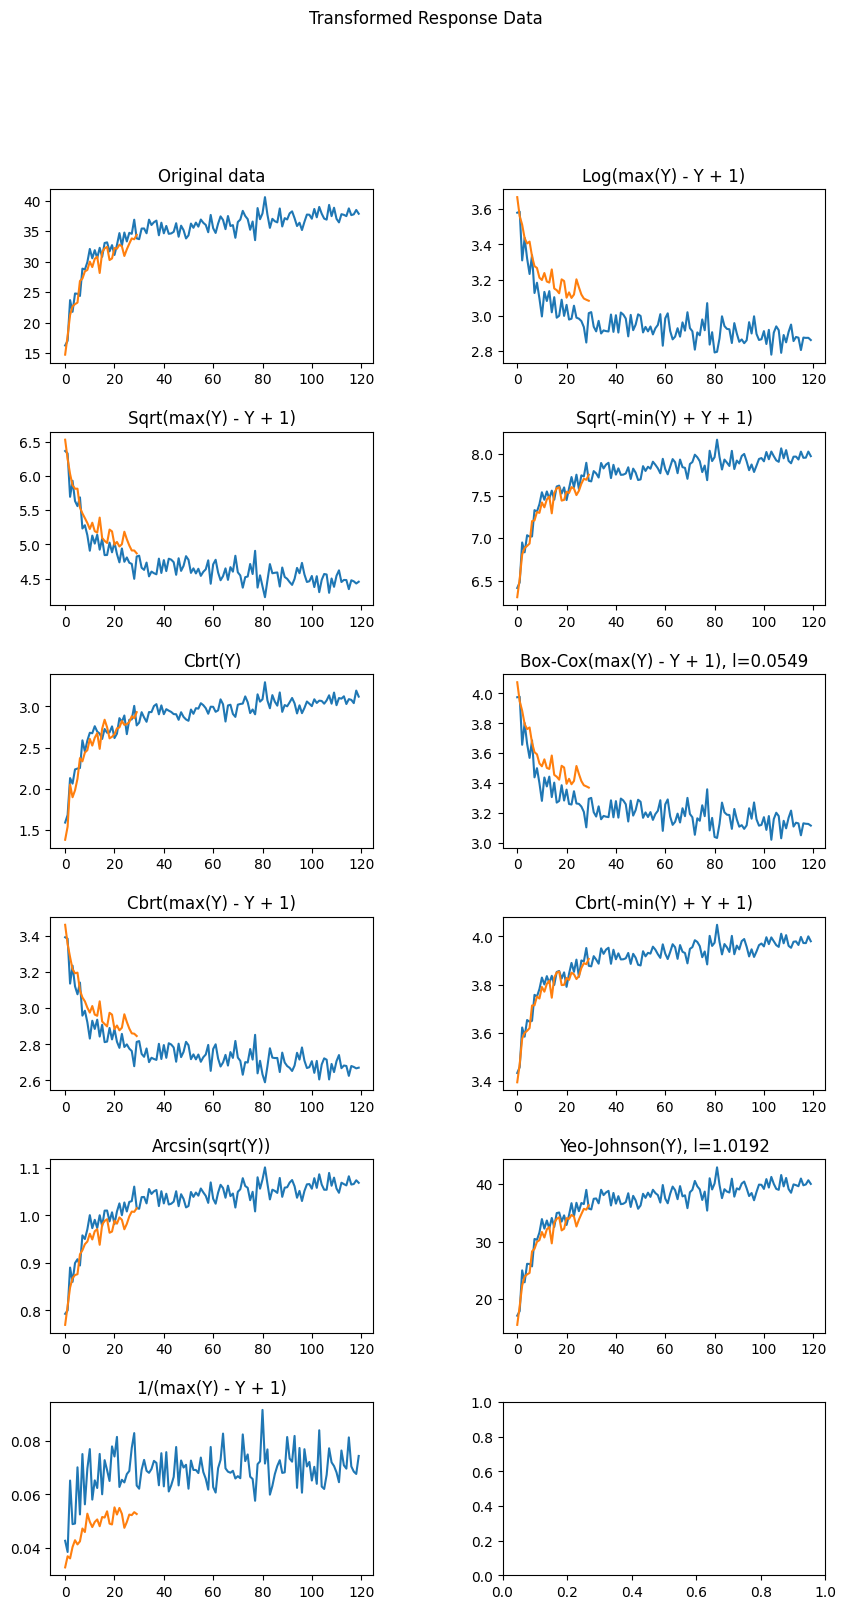

In [195]:
# Plotting the response data

fig, ax = plt.subplots(nrows=math.ceil(len(trans_list)/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list)/2)),squeeze=False)
plt.suptitle("Transformed Response Data")
ax = ax.flatten()

for idx, trans in enumerate(trans_list):
    data = trans[0]
    scarce = data.loc[data.scarce == 1]
    control = data.loc[data.scarce == 0]
    label = trans[1]
    
    scarce_mean = np.array(scarce.groupby('trialNumbers').mean()['expectedScores'])
    control_mean = np.array(control.groupby('trialNumbers').mean()['expectedScores'])
    ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
    ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
    ax[idx].set_title(label)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [196]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
formula = "expectedScores ~ C(trialNumbers) + C(scarce)"

In [197]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = []

mixed = True

for idx, trans in enumerate(trans_list):
    if mixed:
        glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
    else:
        glm = smf.glm(formula=formula, data=trans[0])

    results = glm.fit()

    print("\n{}:".format(trans[1]))
    print(results.summary())
    
    resids = results.resid_response if not mixed else results.resid
    normaltest = scipy.stats.normaltest(resids)
    all_residuals.append((
        resids,
        trans[1],
        normaltest
    ))



Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                191.5324      
Min. group size:    30        Log-Likelihood:       -61730.8613   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               14.980    1.560  9.599 0.000 11.921 18.038
C(trialNumbers)[T.2]     1.908    1.381  1.382 0.167 -0.798  4.614
C(trialNumbers)[T.3]     6.979    1.381  5.055 0.000  4.273  9.685
C(trialNumbers)[T.4]     6.700    1.381  4.853 0.000  3.995  9.406
C(trialNumbers)[T.5]     8.407    1.381  6.090 0.000  5.701 1


Log(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                0.3560        
Min. group size:    30        Log-Likelihood:       -14237.8013   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.683    0.058  63.626 0.000  3.570  3.796
C(trialNumbers)[T.2]   -0.050    0.060  -0.835 0.404 -0.166  0.067
C(trialNumbers)[T.3]   -0.213    0.060  -3.573 0.000 -0.329 -0.096
C(trialNumbers)[T.4]   -0.186    0.060  -3.119 0.002 -0.302 -0.069
C(trialNumbers)[T.5]   -0.259    0.060  -4.348 0.000 -0


Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                1.8263        
Min. group size:    30        Log-Likelihood:       -26605.8954   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               6.536    0.143  45.768 0.000  6.256  6.816
C(trialNumbers)[T.2]   -0.156    0.135  -1.161 0.246 -0.421  0.108
C(trialNumbers)[T.3]   -0.587    0.135  -4.353 0.000 -0.851 -0.323
C(trialNumbers)[T.4]   -0.548    0.135  -4.069 0.000 -0.813 -0.284
C(trialNumbers)[T.5]   -0.724    0.135  -5.370 0.000 -


Sqrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   15210    Method:              REML          
No. Groups:         201      Scale:               0.9603        
Min. group size:    30       Log-Likelihood:      -21784.7807   
Max. group size:    120      Converged:           Yes           
Mean group size:    75.7                                        
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              6.328    0.113 56.157 0.000  6.107  6.549
C(trialNumbers)[T.2]   0.140    0.098  1.432 0.152 -0.052  0.332
C(trialNumbers)[T.3]   0.521    0.098  5.333 0.000  0.330  0.713
C(trialNumbers)[T.4]   0.501    0.098  5.125 0.000  0.309  0.693
C(trialNumbers)[T.5]   0.615    0.098  6.293 0.000  0.424  0.807
C(trialNumbers)


Cbrt(Y):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   15210    Method:              REML          
No. Groups:         201      Scale:               0.8787        
Min. group size:    30       Log-Likelihood:      -21147.4526   
Max. group size:    120      Converged:           Yes           
Mean group size:    75.7                                        
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.459    0.120 12.149 0.000  1.224  1.694
C(trialNumbers)[T.2]   0.125    0.094  1.339 0.181 -0.058  0.308
C(trialNumbers)[T.3]   0.604    0.094  6.455 0.000  0.420  0.787
C(trialNumbers)[T.4]   0.494    0.094  5.285 0.000  0.311  0.677
C(trialNumbers)[T.5]   0.623    0.094  6.664 0.000  0.440  0.806
C(trialNumbers)[T.6]   0.698 


Box-Cox(max(Y) - Y + 1), l=0.0549:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                0.4883        
Min. group size:    30        Log-Likelihood:       -16625.7827   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               4.092    0.069  59.734 0.000  3.958  4.227
C(trialNumbers)[T.2]   -0.061    0.070  -0.877 0.381 -0.198  0.076
C(trialNumbers)[T.3]   -0.255    0.070  -3.661 0.000 -0.392 -0.119
C(trialNumbers)[T.4]   -0.225    0.070  -3.231 0.001 -0.362 -0.089
C(trialNumbers)[T.5]   -0.312    0.070  -


Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                0.2869        
Min. group size:    30        Log-Likelihood:       -12632.2422   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               3.470    0.055  62.915 0.000  3.362  3.578
C(trialNumbers)[T.2]   -0.057    0.053  -1.065 0.287 -0.162  0.048
C(trialNumbers)[T.3]   -0.219    0.053  -4.099 0.000 -0.324 -0.114
C(trialNumbers)[T.4]   -0.201    0.053  -3.770 0.000 -0.306 -0.097
C(trialNumbers)[T.5]   -0.271    0.053  -5.069 0.000 -


Cbrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   15210    Method:              REML          
No. Groups:         201      Scale:               0.1199        
Min. group size:    30       Log-Likelihood:      -6090.4821    
Max. group size:    120      Converged:           Yes           
Mean group size:    75.7                                        
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              3.404    0.040 85.552 0.000  3.326  3.482
C(trialNumbers)[T.2]   0.049    0.035  1.430 0.153 -0.018  0.117
C(trialNumbers)[T.3]   0.185    0.035  5.361 0.000  0.117  0.253
C(trialNumbers)[T.4]   0.178    0.035  5.149 0.000  0.110  0.246
C(trialNumbers)[T.5]   0.217    0.035  6.284 0.000  0.149  0.285
C(trialNumbers)


Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   15210    Method:              REML          
No. Groups:         201      Scale:               0.0352        
Min. group size:    30       Log-Likelihood:      3187.1161     
Max. group size:    120      Converged:           Yes           
Mean group size:    75.7                                        
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.771    0.020 37.823 0.000  0.731  0.810
C(trialNumbers)[T.2]   0.023    0.019  1.236 0.217 -0.014  0.060
C(trialNumbers)[T.3]   0.088    0.019  4.710 0.000  0.051  0.125
C(trialNumbers)[T.4]   0.083    0.019  4.412 0.000  0.046  0.119
C(trialNumbers)[T.5]   0.106    0.019  5.660 0.000  0.069  0.143
C(trialNumbers)[T.6] 


Yeo-Johnson(Y), l=1.0192:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   15210     Method:               REML          
No. Groups:         201       Scale:                215.7866      
Min. group size:    30        Log-Likelihood:       -62629.6667   
Max. group size:    120       Converged:            Yes           
Mean group size:    75.7                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               15.789    1.653  9.555 0.000 12.550 19.028
C(trialNumbers)[T.2]     2.017    1.465  1.377 0.169 -0.855  4.889
C(trialNumbers)[T.3]     7.362    1.465  5.024 0.000  4.490 10.234
C(trialNumbers)[T.4]     7.072    1.465  4.827 0.000  4.200  9.944
C(trialNumbers)[T.5]     8.888    1.465  6.065 0.0

/Volumes/DataDrive/mcl-scarcity-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



1/(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    15210    Method:              REML          
No. Groups:          201      Scale:               0.0038        
Min. group size:     30       Log-Likelihood:      20181.4617    
Max. group size:     120      Converged:           Yes           
Mean group size:     75.7                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.029    0.005  6.000 0.000  0.019  0.038
C(trialNumbers)[T.2]   -0.000    0.006 -0.012 0.991 -0.012  0.012
C(trialNumbers)[T.3]    0.013    0.006  2.139 0.032  0.001  0.025
C(trialNumbers)[T.4]    0.007    0.006  1.130 0.259 -0.005  0.019
C(trialNumbers)[T.5]    0.008    0.006  1.354 0.176 -0.004  0.020
C(t

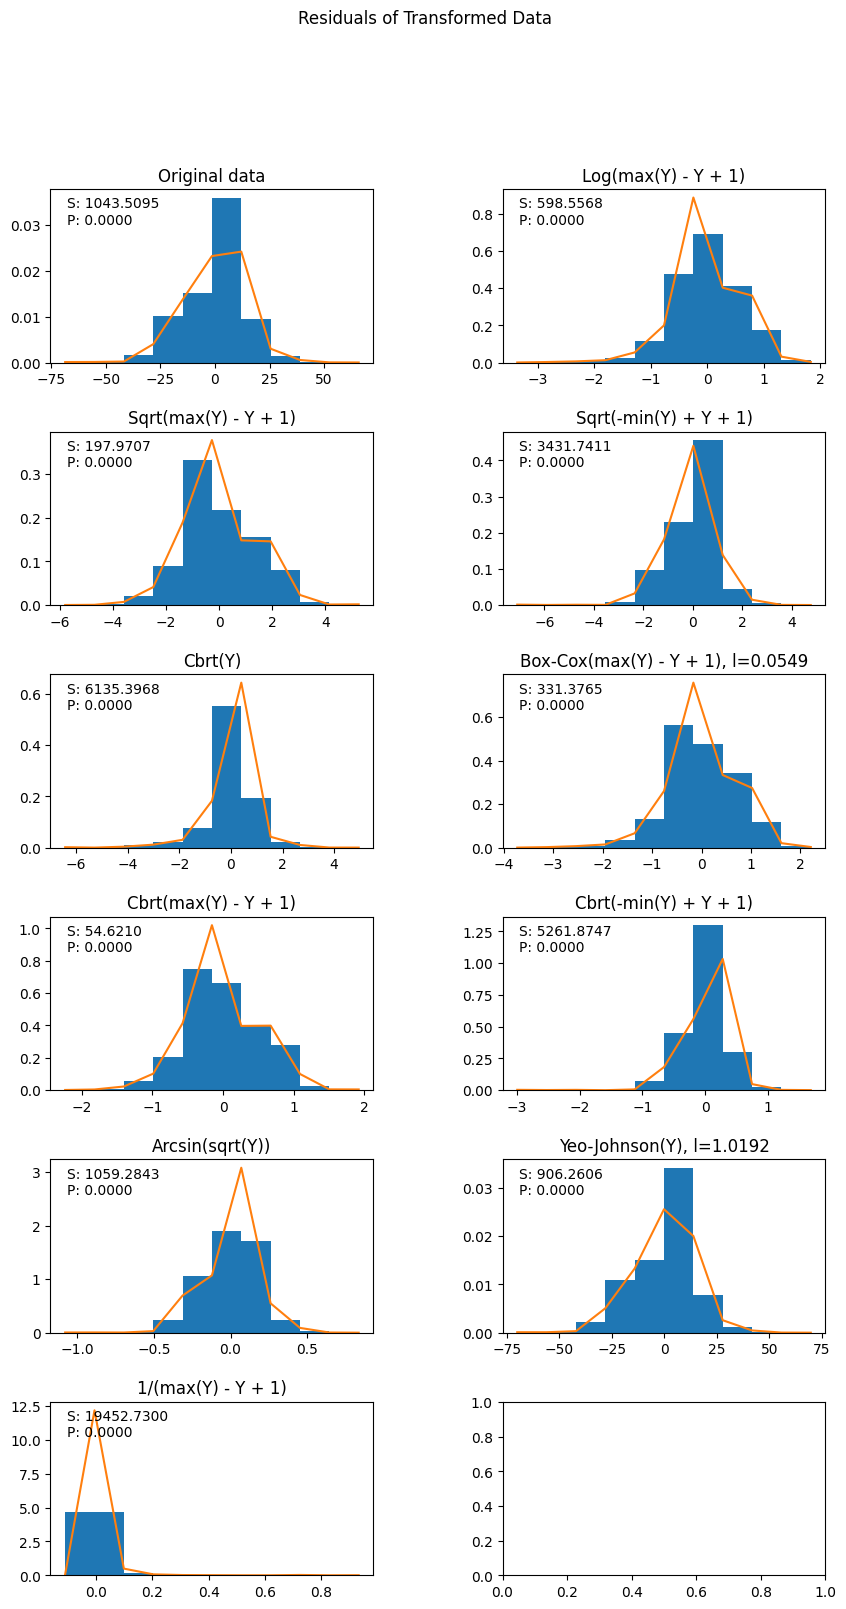

In [198]:
# Plotting residuals for all GLM Models

fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals)/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals)/2)),squeeze=False)
plt.suptitle("Residuals of Transformed Data")
ax = ax.flatten()

for idx, trans in enumerate(all_residuals):
    data = trans[0]
    label = trans[1]
    normaltest = trans[2]
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [199]:
# data which is to be used for the remainder of the analysis

analysis_data = transformed_trials_df

In [200]:
# Scarce

scarce = analysis_data.loc[analysis_data.scarce == 1]

scarce.corr()

control = analysis_data.loc[analysis_data.scarce == 0]

control.corr()

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,rewardsWithheld
trialScores,1.000000,0.709133,0.099044,0.474942,0.163147,NaN,0.163147,NaN,NaN
expectedScores,0.709133,1.000000,0.130469,0.649456,0.215957,NaN,0.215957,NaN,NaN
numClicks,0.099044,0.130469,1.000000,0.222453,-0.015735,NaN,-0.015735,NaN,NaN
avgClickLevel,0.474942,0.649456,0.222453,1.000000,0.288560,NaN,0.288560,NaN,NaN
trialNumbers,0.163147,0.215957,-0.015735,0.288560,1.000000,NaN,1.000000,NaN,NaN
scarce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numRewardedTrials,0.163147,0.215957,-0.015735,0.288560,1.000000,NaN,1.000000,NaN,NaN
numUnrewardedTrials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rewardsWithheld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1.1.0 - Linear Regression: Finding Cut-off Point for Learning Phase

### Finding Cut-off Point for Scarce Condition

In [429]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1]

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_z_scores_scarce = []
scarce_plot_data = []
for trialNum in range(2,60,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    if mixed:
        glm_1 = smf.mixedlm(formula=formula, data=partition_1_df, groups=partition_1_df['workerId'])
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_1 = smf.glm(formula=formula, data=partition_1_df)
        glm_2 = smf.glm(formula=formula, data=partition_2_df)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    b1 = results_1.params['trialNumbers']
    b2 = results_2.params['trialNumbers']
    i1 = results_1.params['Intercept']
    i2 = results_2.params['Intercept']
    se1 = results_1.bse['trialNumbers']
    se2 = results_2.bse['trialNumbers']
    
    corr_1 = np.abs(partition_1_df.corr()['expectedScores']['trialNumbers'])
    corr_2 = np.abs(partition_2_df.corr()['expectedScores']['trialNumbers'])
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_scarce.append((trialNum, pvalue, z, bdiff, corr_1, corr_2))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_scarce[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[8.]


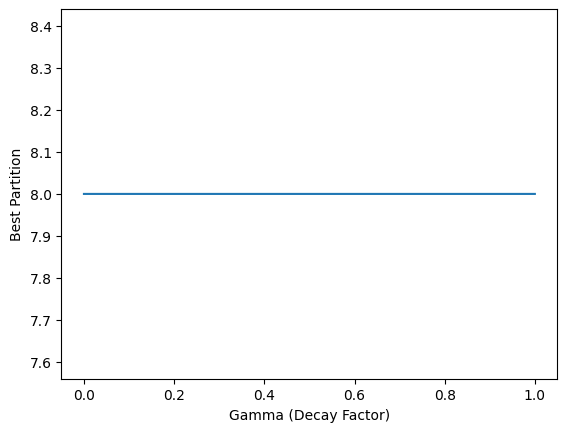

In [430]:
# Finding the best partition of all significant ones 

sig_z_scores_scarce = np.array(sig_z_scores_scarce)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers


g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    # partition_scores = sig_z_scores_scarce[:,2] * (gamma ** sig_z_scores_scarce[:,0])
    
    # Sum of absolute correlation coeffs
    partition_scores = sig_z_scores_scarce[:,4] + sig_z_scores_scarce[:,5]
    
    # Absolute z-score 
    #partition_scores = sig_z_scores_scarce[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_scarce[:,3]
    best_partition = sig_z_scores_scarce[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


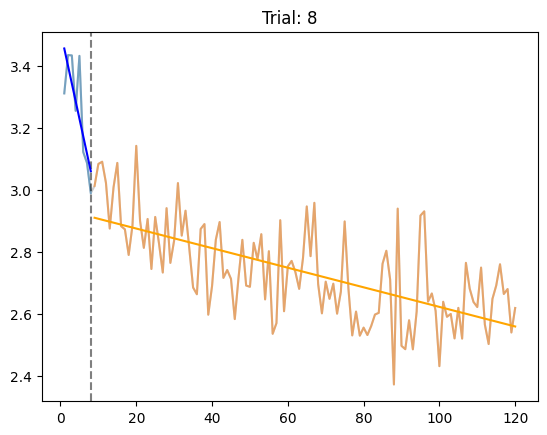

In [431]:
# Plotting candidate partitions - scarce
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in candidate_plot_data_scarce:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [250]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Cut-off Point for Control Condition

In [367]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 0]

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_z_scores_control = []
control_plot_data = []
for trialNum in range(2,28,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    if mixed:
        glm_1 = smf.mixedlm(formula=formula, data=partition_1_df, groups=partition_1_df['workerId'])
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_1 = smf.glm(formula=formula, data=partition_1_df)
        glm_2 = smf.glm(formula=formula, data=partition_2_df)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    b1 = results_1.params['trialNumbers']
    b2 = results_2.params['trialNumbers']
    i1 = results_1.params['Intercept']
    i2 = results_2.params['Intercept']
    se1 = results_1.bse['trialNumbers']
    se2 = results_2.bse['trialNumbers']
    
    corr_1 = np.abs(partition_1_df.corr()['expectedScores']['trialNumbers'])
    corr_2 = np.abs(partition_2_df.corr()['expectedScores']['trialNumbers'])
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_control.append((trialNum, pvalue, z, bdiff, corr_1, corr_2))
        
    x1 = all_trial_nos_control[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_control[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[6.]


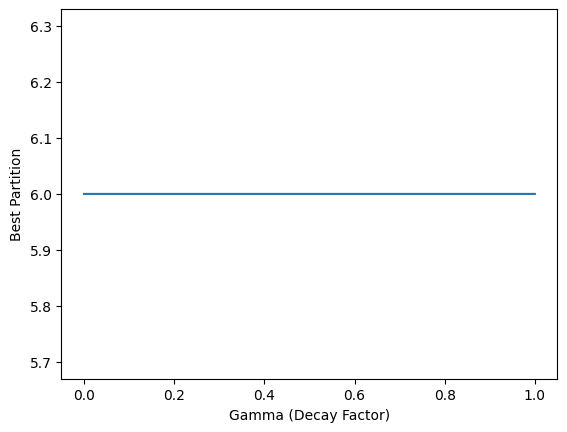

In [372]:
# Finding the best partition of all significant ones

sig_z_scores_control = np.array(sig_z_scores_control)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers


g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    #partition_scores = sig_z_scores_control[:,2] * (gamma ** sig_z_scores_control[:,0])
    
    # Sum of absolute correlation coeffs
    #partition_scores = sig_z_scores_control[:,4] + sig_z_scores_control[:,5]
    
    # Absolute z-score 
    #partition_scores = sig_z_scores_control[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_scarce[:,3]
    best_partition = sig_z_scores_control[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


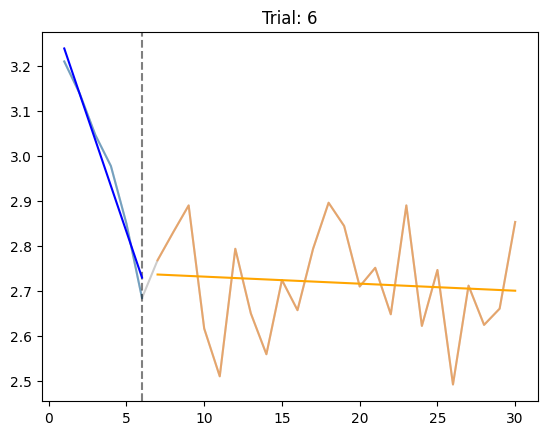

In [373]:
# Plotting candidate partitions - scarce
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in candidate_plot_data_control:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [254]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

### Finding Cut-off Point for Both Conditions Together

In [390]:
# GLM 3 - finding cut off point of both phases together

test_df = analysis_data

mixed = False
    
# For all trials
relevant_trials = test_df

all_trials_mean = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos = list(range(1,len(all_trials_mean)+1))

sig_z_scores_all = []
all_plot_data = []
for trialNum in range(2,60,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    if mixed:
        glm_1 = smf.mixedlm(formula=formula, data=partition_1_df, groups=partition_1_df['workerId'])
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_1 = smf.glm(formula=formula, data=partition_1_df)
        glm_2 = smf.glm(formula=formula, data=partition_2_df)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    corr_1 = np.abs(partition_1_df.corr()['expectedScores']['trialNumbers'])
    corr_2 = np.abs(partition_2_df.corr()['expectedScores']['trialNumbers'])

    b1 = results_1.params['trialNumbers']
    b2 = results_2.params['trialNumbers']
    i1 = results_1.params['Intercept']
    i2 = results_2.params['Intercept']
    se1 = results_1.bse['trialNumbers']
    se2 = results_2.bse['trialNumbers']
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_all.append((trialNum, pvalue, z, bdiff, corr_1, corr_2))
        
    x1 = all_trial_nos[0:len(partition_1_df_mean)]
    x2 = all_trial_nos[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    all_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[14.]


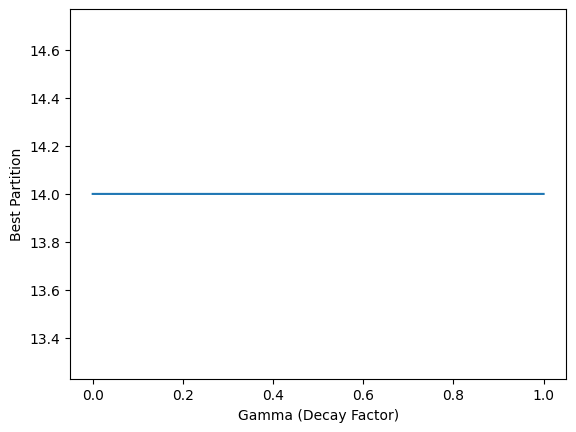

In [391]:
# Finding the best partition of all significant ones

sig_z_scores_all = np.array(sig_z_scores_all)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers


g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    #partition_scores = sig_z_scores_all[:,2] * (gamma ** sig_z_scores_all[:,0])
    
    # Sum of absolute correlation coeffs
    partition_scores = sig_z_scores_all[:,4] + sig_z_scores_all[:,5]
    
    # Absolute z-score 
    #partition_scores = sig_z_scores_all[:,2]
    
    # Absolute difference in slope
    #partition_scores = sig_z_scores_all[:,3]
    
    best_partition = sig_z_scores_all[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


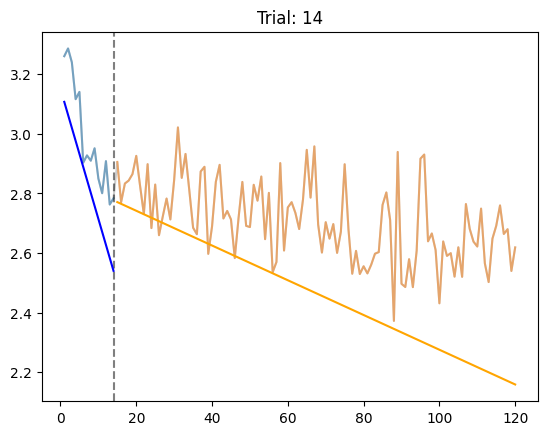

In [392]:
# Plotting candidate partitions - all
candidate_plot_data_all = [data for data in all_plot_data if float(data[0]) in partition_candidates]

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in candidate_plot_data_all:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos, all_trials_mean, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [223]:
all_partition = 7 # Somehow choose based on possible candidates

# Separating into learning and performance phase
all_learning_data = analysis_data.loc[(analysis_data.trialNumbers <= control_partition)]
all_performance_data = analysis_data.loc[(analysis_data.trialNumbers > control_partition)]

# Without transformation
all_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= scarce_partition)]
all_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==0) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
all_partition_plot_data = [data for data in candidate_plot_data_all if data[0] == all_partition][0]

In [224]:
# Re-partition individual condition learning/performance phases based on joint partition

# Separating into learning and performance phase
control_learning_data_joint = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= all_partition)]
control_performance_data_joint = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > all_partition)]

# Without transformation
control_learning_data_orig_joint = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= all_partition)]
control_performance_data_orig_joint = filtered_data.loc[(filtered_data.scarce ==0) & (filtered_data.trialNumbers > all_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data_joint = [data for data in control_plot_data if data[0] == all_partition][0]

In [225]:
# Re-partition individual condition learning/performance phases based on joint partition

# Separating into learning and performance phase
scarce_learning_data_joint = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= all_partition)]
scarce_performance_data_joint = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > all_partition)]

# Without transformation
scarce_learning_data_orig_joint = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= all_partition)]
scarce_performance_data_orig_joint = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > all_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data_joint = [data for data in scarce_plot_data if data[0] == all_partition][0]

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

### Finding Best Model for Scarce Condition

In [201]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []
for trialNum in range(2,60,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Should the model formula now include a separate regressor for just C(isPerformance)?
    two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    #two_slope_formula = "expectedScores ~ trialNumbers + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept'] #+ results_1.params['C(isPerformanceTrial)[T.1]']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

Partition candidates: 
[12.]


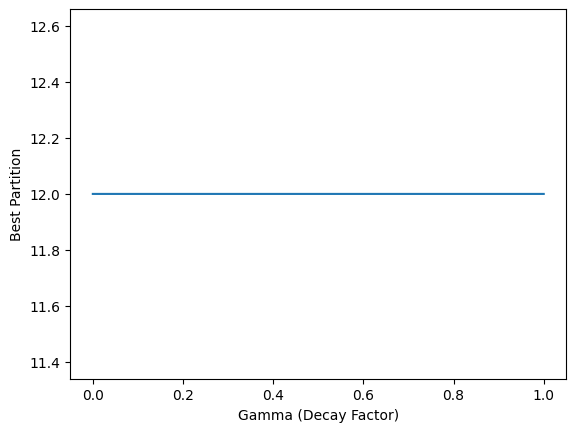

In [202]:
# Finding the best partition of all significant ones 

sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_scarce[:,1]
    best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [203]:
# Showing GLM results - scarce
candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_scarce:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 12

Two-Slope Model:
BIC LLF: 105709.2436

BIC Deviance: 3909234.0913

AIC: 105679.5938

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                12240
Model:                            GLM   Df Residuals:                    12236
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          328.90
Method:                          IRLS   Log-Likelihood:                -52836.
Date:                Thu, 13 Oct 2022   Deviance:                   4.0244e+06
Time:                        13:58:04   Pearson chi2:                 4.02e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04328
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
--

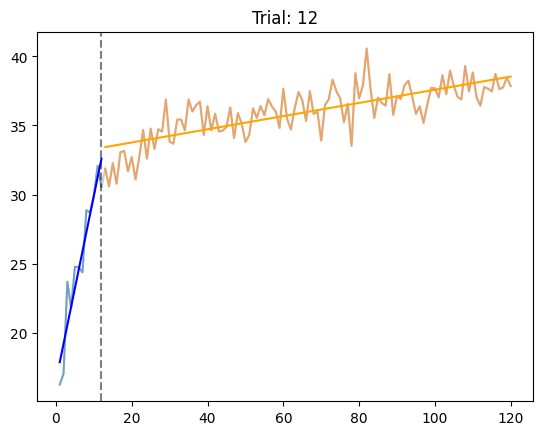

In [204]:
# Plotting candidate partitions - control
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False
error = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
        
    if error:
        plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [205]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [206]:
relevant_trials

,trialScores,expectedScores,numClicks,avgClickLevel,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId,rewardsWithheld,isPerformanceTrial
30,-7.50,-0.50,2,1.0,1,1,0,0,631a24dfca851aac1863e4a4,True,0
31,50.50,1.50,2,1.0,2,1,0,1,631a24dfca851aac1863e4a4,False,0
32,58.75,1.75,1,1.0,3,1,1,1,631a24dfca851aac1863e4a4,False,0
33,18.50,-0.50,2,1.0,4,1,2,1,631a24dfca851aac1863e4a4,True,0
34,-31.25,3.75,1,1.0,5,1,2,2,631a24dfca851aac1863e4a4,True,0
...,...,...,...,...,...,...,...,...,...,...,...
15145,42.00,47.00,4,3.0,116,1,30,85,5f946b72d654c628ea868716,True,1
15146,46.25,47.25,3,3.0,117,1,30,86,5f946b72d654c628ea868716,True,1
15147,21.50,22.50,6,3.0,118,1,30,87,5f946b72d654c628ea868716,True,1
15148,52.50,47.50,2,3.0,119,1,30,88,5f946b72d654c628ea868716,True,1


In [207]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.scarce == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,30,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Should the model formula now include a separate regressor for just C(isPerformance)?
    two_slope_formula = "expectedScores ~ trialNumbers + C(scarce) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
    one_slope_formula = "expectedScores ~ trialNumbers + C(scarce)"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
#     print(bic1, bic2)
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [208]:
sig_bic_scores_control

[(2, 25919.051103779886),
 (3, 25915.586935532127),
 (4, 25913.406591856463),
 (5, 25911.064894153475),
 (6, 25907.659024533667),
 (7, 25907.247729018884),
 (8, 25906.97002361501),
 (9, 25907.11043147923),
 (10, 25907.752337825477),
 (11, 25908.08768659042),
 (12, 25910.0598944108),
 (13, 25911.028145259144),
 (14, 25912.13401134662),
 (15, 25917.18865639012),
 (16, 25917.872196058077),
 (17, 25918.10985033543),
 (18, 25918.206630304732),
 (19, 25922.951471009983),
 (20, 25926.91682136976),
 (21, 25928.25102900278)]

Partition candidates: 
[8.]


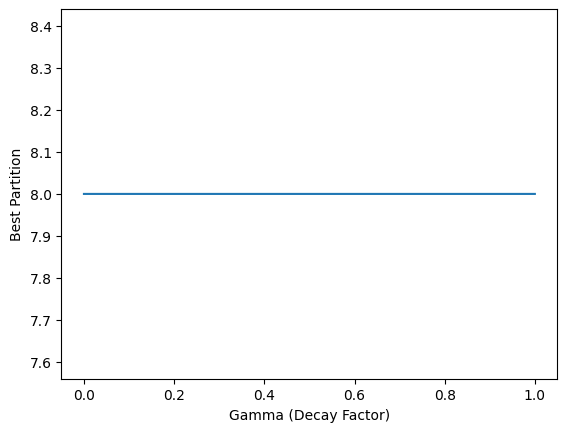

In [209]:
# Finding the best partition of all significant ones 

sig_bic_scores_control = np.array(sig_bic_scores_control)

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Minimum bic
    partition_scores = sig_bic_scores_control[:,1]
    best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


In [210]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

significant_glm_data_control = [data for data in control_glm_results if float(data[0]) in sig_bic_scores_control[:,0]]

which_results = "all" #all, significant, candidates

if which_results == "candidates":
    result_data = candidate_glm_results_control
elif which_results == "significant":
    result_data = significant_glm_data_control
else:
    result_data = control_glm_results
    
filter_results = [6, 11]
for trialNum, results_1, results_2 in result_data:
    if len(filter_results) > 0 and trialNum not in filter_results: continue
    print("\nTrial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())



Trial Num: 6

Two-Slope Model:
BIC LLF: 25907.6590

BIC Deviance: 1033116.9516

AIC: 25883.6738

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                 2970
Model:                            GLM   Df Residuals:                     2966
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          356.32
Method:                          IRLS   Log-Likelihood:                -12938.
Date:                Thu, 13 Oct 2022   Deviance:                   1.0568e+06
Time:                        13:58:06   Pearson chi2:                 1.06e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06010
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
----

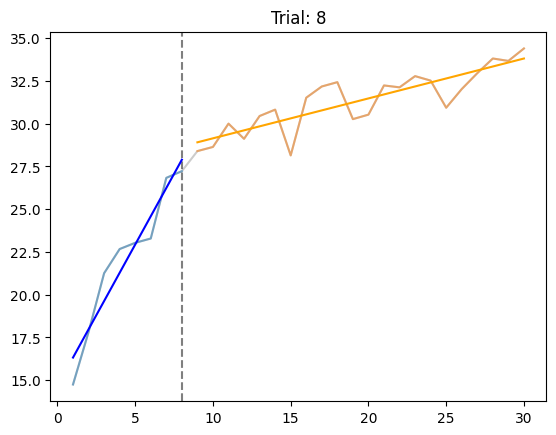

In [211]:
# Plotting candidate partitions - scarce
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [212]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.scarce == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.scarce == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

# 1.1.2 - Linear Regression: Finding Cut-off Point for Learning Phase while enforcing Intercept

### Finding Cut-off Point for Scarce Condition

In [417]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 1]

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_z_scores_scarce = []
scarce_plot_data = []
for trialNum in range(2,60,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    
    formula = "expectedScores ~ trialNumbers"
    if mixed:
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_2 = smf.glm(formula=formula, data=partition_2_df)
    try:
        results_2 = glm_2.fit()
    except:
        continue
        
    b2 = results_2.params['trialNumbers']
    i2 = results_2.params['Intercept']
    se2 = results_2.bse['trialNumbers']
    
    intercept_shift = (b2 * trialNum + i2)
    # Shift the learning data based on this
    partition_1_shifted_df = partition_1_df.copy()
    # Reverse the trial numbers of the learning phase
    partition_1_shifted_df['trialNumbers'] = -partition_1_shifted_df['trialNumbers'] + trialNum
    partition_1_shifted_df['expectedScores'] = partition_1_shifted_df['expectedScores'] - intercept_shift
    partition_1_df_mean_shift = partition_1_shifted_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Comment these out later to plot the original data
#     partition_1_df = partition_1_shifted_df
#     partition_1_df_mean = partition_1_df_mean_shift
    
    # Regress for learning phase on shifted data with constrained intercept
    no_int_formula = formula + " -1"
    if mixed:
        glm_1 = smf.mixedlm(formula=no_int_formula, data=partition_1_shifted_df, groups=partition_1_shifted_df['workerId'])
    else:
        glm_1 = smf.glm(formula=no_int_formula, data=partition_1_shifted_df)
    try:
        results_1 = glm_1.fit()
    except:
        continue
    
    # Invert the slope 
    b1 = -results_1.params['trialNumbers']
    
    # intercept relevant only for plotting
    i1 = -b1 * trialNum + intercept_shift
    se1 = results_1.bse['trialNumbers']
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_scarce.append((trialNum, pvalue, z, bdiff))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_scarce[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[3.]


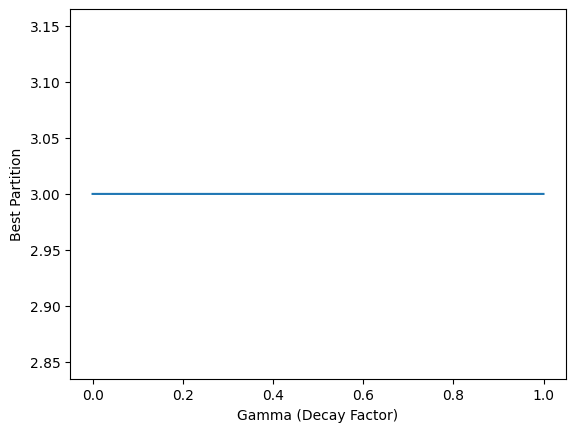

In [420]:
# Finding the best partition of all significant ones 

sig_z_scores_scarce = np.array(sig_z_scores_scarce)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    # partition_scores = sig_z_scores_scarce[:,2] * (gamma ** sig_z_scores_scarce[:,0])
    
    # Absolute z-score
    # partition_scores = sig_z_scores_scarce[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_scarce[:,3]
    best_partition = sig_z_scores_scarce[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


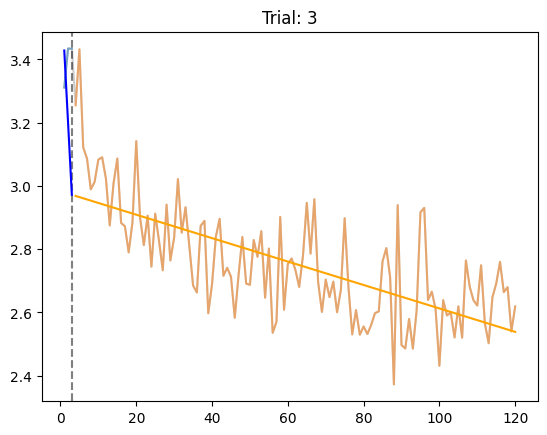

In [421]:
# Plotting candidate partitions - control
candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_z_scores_scarce[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_scarce
elif which_plot == "significant":
    plot_data = significant_plot_data_scarce
else:
    plot_data = scarce_plot_data

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Slope lines of two-slope model
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [138]:
scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Cut-off Point for Control Condition

In [424]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.scarce == 0]

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean()["expectedScores"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_z_scores_control = []
control_plot_data = []
for trialNum in range(2,15,1):
    # print(trialNum)
    partition_1_df = relevant_trials.loc[relevant_trials.trialNumbers <= trialNum]
    partition_2_df = relevant_trials.loc[relevant_trials.trialNumbers > trialNum]
    partition_1_df_mean = partition_1_df.groupby("trialNumbers").mean()["expectedScores"]
    partition_2_df_mean = partition_2_df.groupby("trialNumbers").mean()["expectedScores"]
    
    
    formula = "expectedScores ~ trialNumbers"
    if mixed:
        glm_2 = smf.mixedlm(formula=formula, data=partition_2_df, groups=partition_2_df['workerId'])
    else:
        glm_2 = smf.glm(formula=formula, data=partition_2_df)
    try:
        results_2 = glm_2.fit()
    except:
        continue
        
    b2 = results_2.params['trialNumbers']
    i2 = results_2.params['Intercept']
    se2 = results_2.bse['trialNumbers']
    
    intercept_shift = (b2 * trialNum + i2)
    # Shift the learning data based on this
    partition_1_shifted_df = partition_1_df.copy()
    # Reverse the trial numbers of the learning phase
    partition_1_shifted_df['trialNumbers'] = -partition_1_shifted_df['trialNumbers'] + trialNum
    partition_1_shifted_df['expectedScores'] = partition_1_shifted_df['expectedScores'] - intercept_shift
    partition_1_df_mean_shift = partition_1_shifted_df.groupby("trialNumbers").mean()["expectedScores"]
    
    # Comment these out later to plot the original data
#     partition_1_df = partition_1_shifted_df
#     partition_1_df_mean = partition_1_df_mean_shift
    
    # Regress for learning phase on shifted data with constrained intercept
    no_int_formula = formula + " -1"
    if mixed:
        glm_1 = smf.mixedlm(formula=no_int_formula, data=partition_1_shifted_df, groups=partition_1_shifted_df['workerId'])
    else:
        glm_1 = smf.glm(formula=no_int_formula, data=partition_1_shifted_df)
    try:
        results_1 = glm_1.fit()
    except:
        continue
    
    # Invert the slope 
    b1 = -results_1.params['trialNumbers']
    
    # intercept relevant only for plotting
    i1 = -b1 * trialNum + intercept_shift
    se1 = results_1.bse['trialNumbers']
    
    z = np.abs((b1-b2)/np.sqrt(se1**2 + se2**2))
    bdiff = np.abs((b1-b2))

    pvalue = 2 * scipy.stats.norm.cdf(-z)
    
    if(pvalue < 0.05):
        # Save data about significant partitions
        sig_z_scores_control.append((trialNum, pvalue, z, bdiff))
        
    x1 = all_trial_nos_control[0:len(partition_1_df_mean)]
    x2 = all_trial_nos_control[len(partition_1_df_mean):len(partition_1_df_mean)+len(partition_2_df_mean)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_df_mean,
        partition_2_df_mean,
        b1,
        b2,
        i1,
        i2
    ))

Partition candidates: 
[2.]


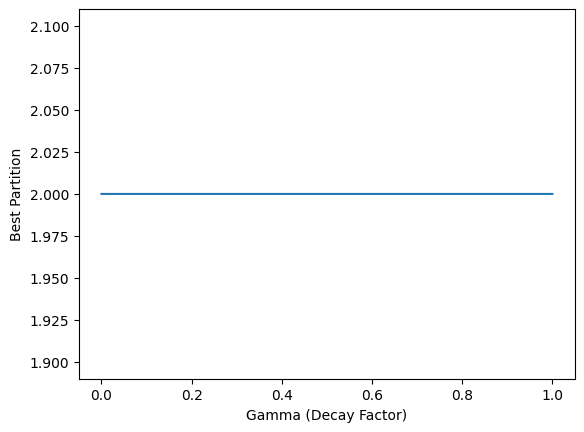

In [427]:
# Finding the best partition of all significant ones 

sig_z_scores_control = np.array(sig_z_scores_control)
gamma = 0.8 # some number between 0 and 1 representing the decay of trial numbers

g_range = np.arange(0, 1, 0.0001)
best_partitions = []

for gamma in g_range:
    # Z-score * (gamma)^trialNum
    # partition_scores = sig_z_scores_control[:,2] * (gamma ** sig_z_scores_control[:,0])
    
    # Absolute z-score
    partition_scores = sig_z_scores_control[:,2]
    
    # Absolute difference in slope
    partition_scores = sig_z_scores_control[:,3]
    best_partition = sig_z_scores_control[np.argmax(partition_scores),0]
    best_partitions.append(best_partition)

partition_candidates = np.unique(best_partitions)
print("Partition candidates: ")
print(partition_candidates)
plt.plot(g_range, best_partitions)
plt.xlabel("Gamma (Decay Factor)")
plt.ylabel("Best Partition")
plt.show()


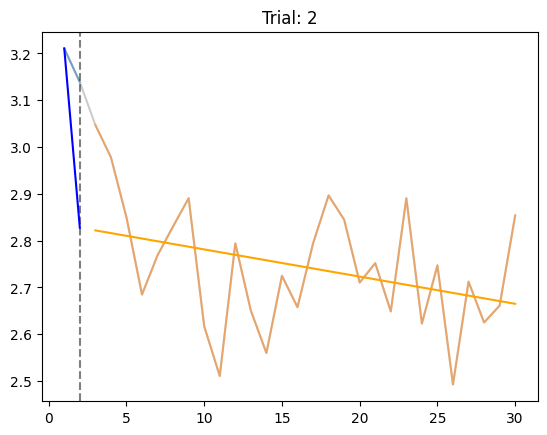

In [428]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_z_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Slope lines of two-slope model
    plt.plot(x1, np.array(x1) * b1 + i1, color='b')
    plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [237]:
scarce_partition = 18 # partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

# Without transformation
scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

# Store the slope, intercept, etc. of the best partition
scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

IndexError: list index out of range

# 1.2 - Linear Regression: Expected Score vs. Trial Number x Condition

In [213]:
# True if using cut-off points found on both condition data
joint_partition = False

if joint_partition:
    control_plot = control_partition_plot_data_joint
    scarce_plot = scarce_partition_plot_data_joint
else:
    control_plot = control_partition_plot_data
    scarce_plot = scarce_partition_plot_data

                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    expectedScores
No. Observations:      2016       Method:                REML          
No. Groups:            201        Scale:                 201.8551      
Min. group size:       8          Log-Likelihood:        -8454.1553    
Max. group size:       12         Converged:             Yes           
Mean group size:       10.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    14.669    1.854  7.913 0.000 11.036 18.302
C(scarce)[T.1]                1.855    2.514  0.738 0.461 -3.072  6.782
trialNumbers                  1.653    0.220  7.501 0.000  1.221  2.085
trialNumbers:C(scarce)[T.1]  -0.314    0.250 -1.256 0.209 -0.803  0.176
Group Var

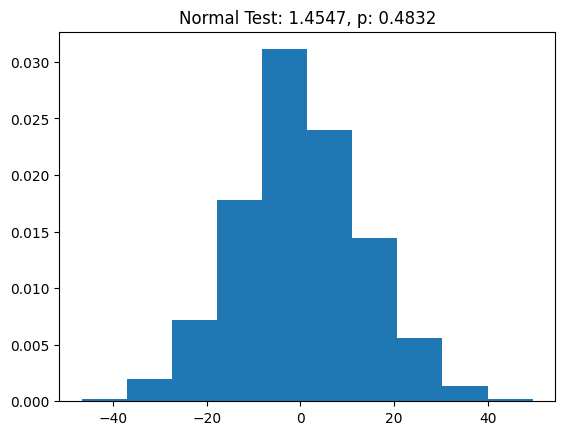

In [214]:
# Learning Phase

if joint_partition:
    learning_df = all_learning_data
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)
#learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
#learning_df = control_learning_data

formula = 'expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

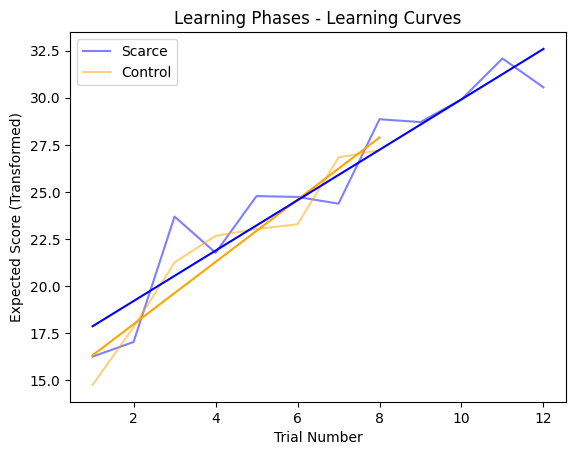

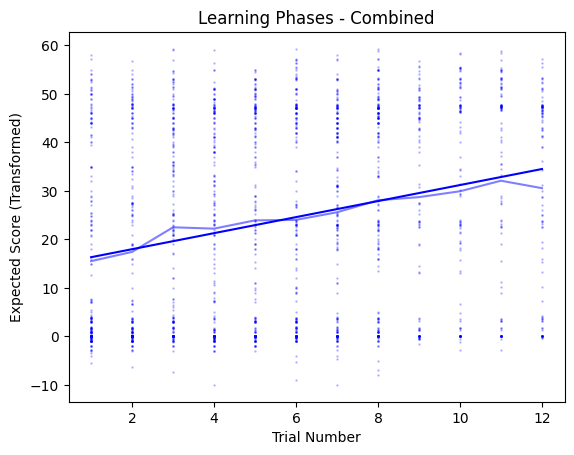

In [215]:
# Plotting the data of both learning phases

x1 = control_plot[1]
x2 = scarce_plot[1]
y1 = control_plot[3]
y2 = scarce_plot[3]
b1 = control_plot[5]
b2 = scarce_plot[5]
i1 = control_plot[7]
i2 = scarce_plot[7]

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.legend()

# Plotting the output of the GLM on the combined data
plt.figure()
y = learning_df.groupby("trialNumbers").mean()["expectedScores"]
y_err = np.abs(learning_df.groupby("trialNumbers").std()["expectedScores"])
x = y.index
b = results.params['trialNumbers']
i = results.params['Intercept']

# Scattering the data points
plt.scatter(learning_df['trialNumbers'], learning_df['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
plt.scatter(learning_df['trialNumbers'], learning_df['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)

plt.plot(x,y,alpha = 0.5, color='b')
# plt.fill_between(x, y + y_err, y - y_err, alpha=0.1)
plt.plot(x, np.array(x) * b + i, color='b')
plt.title("Learning Phases - Combined")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.show()



                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    expectedScores
No. Observations:      13194      Method:                REML          
No. Groups:            201        Scale:                 172.9694      
Min. group size:       22         Log-Likelihood:        -53099.1918   
Max. group size:       108        Converged:             Yes           
Mean group size:       65.6                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    26.807    1.529 17.533 0.000 23.810 29.804
C(scarce)[T.1]                6.010    1.972  3.048 0.002  2.145  9.875
trialNumbers                  0.233    0.044  5.253 0.000  0.146  0.320
trialNumbers:C(scarce)[T.1]  -0.186    0.045 -4.162 0.000 -0.273 -0.098
Group Var

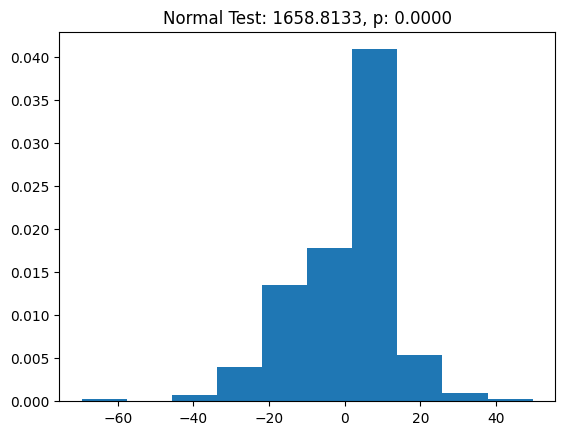

In [216]:
# Performance Phase

if joint_partition:
    performance_df = all_performance_data
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# performance_df = scarce_performance_data

formula = 'expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

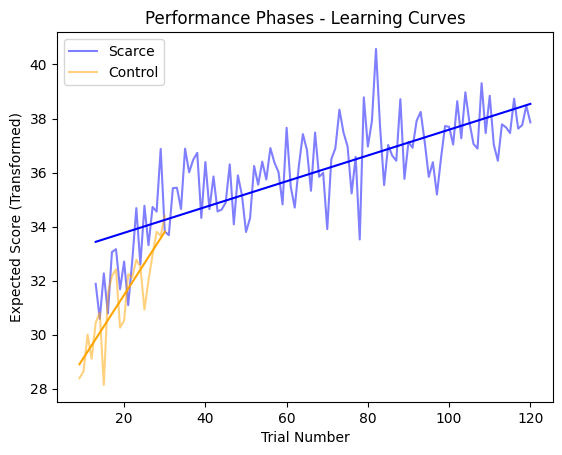

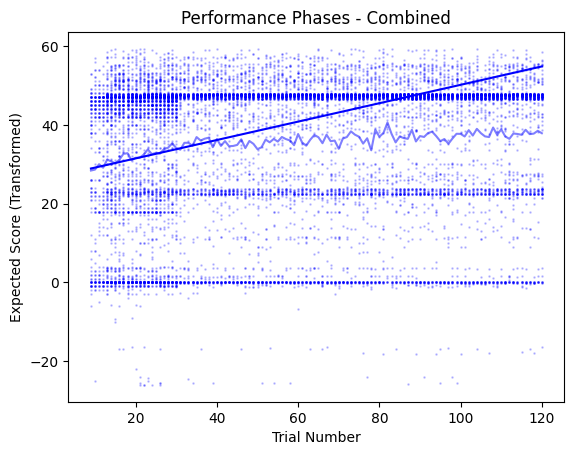

In [217]:
# Plotting the data of both performance phases together

x1 = control_plot[2]
x2 = scarce_plot[2]
y1 = control_plot[4]
y2 = scarce_plot[4]
b1 = control_plot[6]
b2 = scarce_plot[6]
i1 = control_plot[8]
i2 = scarce_plot[8]

plt.plot(x2, y2, color='b', alpha=0.5, label="Scarce")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.legend()

# Plotting the output of the GLM on the combined data
plt.figure()
y = performance_df.groupby("trialNumbers").mean()["expectedScores"]
x = y.index
b = results.params['trialNumbers']
i = results.params['Intercept']

# Scattering the data points
plt.scatter(performance_df['trialNumbers'], performance_df['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
plt.scatter(performance_df['trialNumbers'], performance_df['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)

plt.plot(x,y,alpha = 0.5, color='b')
plt.plot(x, np.array(x) * b + i, color='b')
plt.title("Performance Phases - Combined")
plt.xlabel("Trial Number")
plt.ylabel("Expected Score (Transformed)")
plt.show()


# 1.3 - Linear Regression: Expected Score vs. Num Rewarded Trials

                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      expectedScores
No. Observations:       2016         Method:                  REML          
No. Groups:             201          Scale:                   201.9582      
Min. group size:        8            Log-Likelihood:          -8453.6192    
Max. group size:        12           Converged:               Yes           
Mean group size:        10.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         16.322    1.746  9.347 0.000 12.899 19.744
C(scarce)[T.1]                     1.541    2.401  0.642 0.521 -3.166  6.247
numRewardedTrials                  1.653    0.220  7.499 0.000  1.221  2.085
numRewardedTrials:C

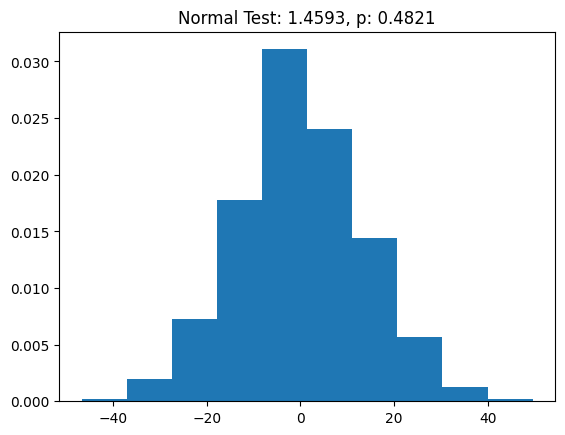

In [220]:
# GLM 2 - Expected score vs num rewarded trials 

learning_df = pd.concat([scarce_learning_data, control_learning_data])

formula = 'expectedScores ~ numRewardedTrials + C(scarce) + numUnrewardedTrials + numRewardedTrials:C(scarce)'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

# 1.4 - Independent Samples T-test

In [172]:
use_transformed = False

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean()
    scarce_averages = scarce_performance_data.groupby('workerId').mean()
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean()
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean()
    

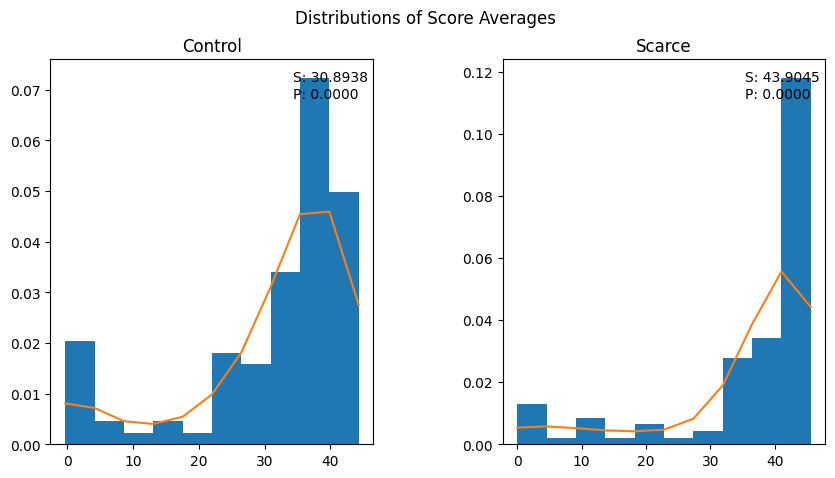

In [173]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Score Averages")
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Scarce")]):
    data = group[0]["expectedScores"]
    label = group[1]
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [174]:
# Perform independent T-test if data is normal

scipy.stats.ttest_ind(scarce_averages.expectedScores, control_averages.expectedScores, equal_var=True, alternative='greater')

two = scipy.stats.ttest_ind(scarce_averages.expectedScores, control_averages.expectedScores, equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages.expectedScores, control_averages.expectedScores, equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages.expectedScores, control_averages.expectedScores, equal_var=True, alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 2.598
	P-value: 0.01008137146991965
Scarce < Control:
	Statistic: 2.598
	P-value: 0.9949593142650401
Scarce > Control:
	Statistic: 2.598
	P-value: 0.005040685734959825


In [176]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages.expectedScores, control_averages.expectedScores, alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages.expectedScores, control_averages.expectedScores, alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages.expectedScores, control_averages.expectedScores, alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 7190.000
	P-value: 2.0829013385827908e-07
Scarce < Control:
	Statistic: 7190.000
	P-value: 0.9999998972034638
Scarce > Control:
	Statistic: 7190.000
	P-value: 1.0414506692913954e-07
